##Bring in libraries and dataframes and set indexes

In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Read in data calibrated VWC and PAW data
Data = pd.read_pickle('.\DataFrames\LysoVWC_df')
Data.columns = Data.columns.swaplevel('Sensor','Depth') #get index in the right order for graphing

#Read in calibration coefficients calculated in C:\GitHubRepos\StonySoilLysimeters\Calibration\CS650Calibration.ipynb
SensorCoefficients = pd.read_pickle('.\Calibration\CS650Calibration.pkl')


#Bring in index for horizion types
HorizonIndex=pd.read_csv('.\IndexFiles\HorizonIndex.csv', #specify file path for data to read in
                         index_col = 0, #Use the first column, which is Date, as an index
                         na_values = 'NAN')

##Produce profile soil water content graphs

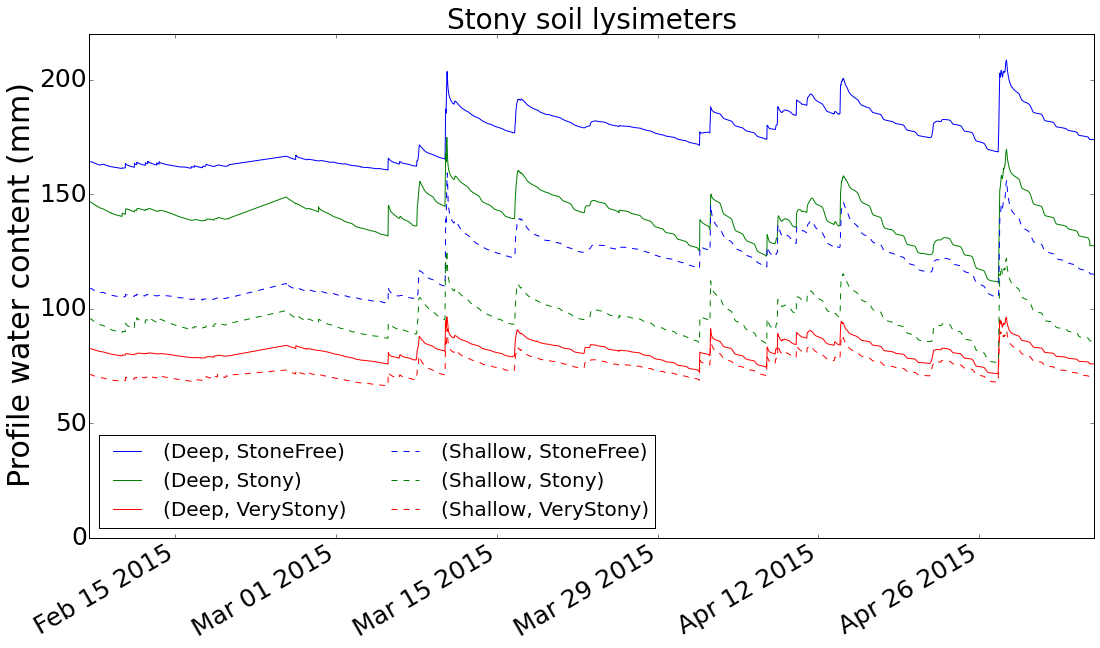

In [4]:
#Calculate treatment means omitting data prior to 2014-11-05 08:00:00 to avoid NaN values
DataMeans =  Data.ix['2014-11-05 08:00:00':'2015-05-5'].groupby(level=['Depth','Gravels','Stones'],axis=1).mean()
DataMeans =  DataMeans.dropna(axis=1) #For some reason it keeps non valid combinations in so need to extract with this function
DataMeans.where(DataMeans<0.7,np.nan,inplace=True)

#Calculate the water content of the soil profile by multiplying the volumetric water content by each layers
#depth and summing.  The 0-15 layers are divided by 2 to average the two readings
ProfileWater = DataMeans.ix[:,'D1'] * 150 + \
               DataMeans.ix[:,'D2'] * 150 + \
               DataMeans.ix[:,'D3'] * 150 + \
               DataMeans.ix[:,'D4'] * 150 
                
ProfileWater.plot(figsize=(18,10),style=['b-','g-','r-','b--','g--','r--'],ylim=(0,220))
plt.ylabel('Profile water content (mm)', fontsize=30);
plt.tick_params(labelsize=25)
plt.title('Stony soil lysimeters', fontsize=28)
plt.legend(fontsize = 20, loc=3, ncol=2)


##Graph plot volumetric water content by layer

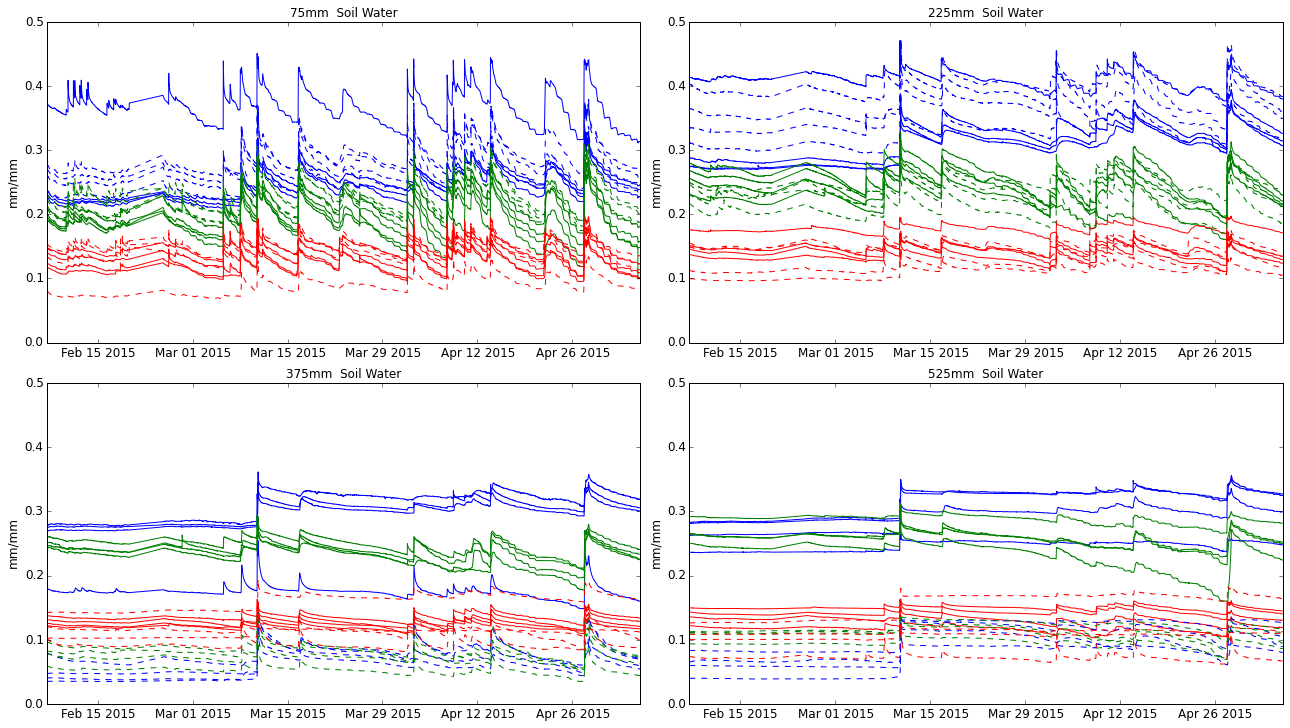

In [5]:
VWCData =  Data.ix['2014-11-05 08:00:00':'2015-05-05'].copy()
VWCData.columns = VWCData.columns.swaplevel('Sensor','Gravels') #get index in the right order for graphing
VWCData.columns = VWCData.columns.swaplevel('Sensor','Stones')  #get index in the right order for graphing
VWCData.columns = VWCData.columns.swaplevel('Sensor','Depth')  #get index in the right order for graphing
VWCData.where(VWCData<0.5,np.nan,inplace=True)

Fig = plt.figure(figsize=(18, 20))

def MakePlot(Position, Column, Depth, LayerThickness, Ymax, DepthLabel):
        Fig.add_subplot(4,Column,Position, color_cycle=['b','b','b','b','g','g','g','g','r','r','r','r','b','b','b','b','g','g','g','g','r','r','r','r'])
        plt.title(DepthLabel + '  Soil Water', fontsize=12);
        plt.plot(VWCData.index,VWCData.Deep.StoneFree.ix[:,Depth]*LayerThickness, '-', label='Deep StoneFree');
        plt.plot(VWCData.index,VWCData.Deep.Stony.ix[:,Depth]*LayerThickness, '-', label='Deep Stoney');
        plt.plot(VWCData.index,VWCData.Deep.VeryStony.ix[:,Depth]*LayerThickness,'-', label='Deep VeryStony');
        plt.plot(VWCData.index,VWCData.Shallow.StoneFree.ix[:,Depth]*LayerThickness, '--', label='Shallow StoneFree');
        plt.plot(VWCData.index,VWCData.Shallow.Stony.ix[:,Depth]*LayerThickness, '--', label='Shallow Stony');
        plt.plot(VWCData.index,VWCData.Shallow.VeryStony.ix[:,Depth]*LayerThickness, '--', label='Shallow VeryStony');
        plt.ylabel('mm/mm', fontsize=12);
        plt.tick_params(labelsize=12);
        plt.ylim(0,Ymax);
        #plt.legend(False)# loc=1, fontsize=13, ncol=2)
        return;
    
MakePlot(1,2,'D1',1,.5, '75mm')
MakePlot(2,2,'D2',1,.5, '225mm')
MakePlot(3,2,'D3',1,.5, '375mm')
MakePlot(4,2,'D4',1,.5, '525mm')

Fig.tight_layout()

##Create and populate Plant Available Water (PAW) data frame

In [5]:
PAW = pd.DataFrame(index = Data.index, columns = Data.columns)  #Set up empty dataframe with the same index and column structure as TDR dataPAW = pd.DataFrame(index = VWC.index, columns = VWC.columns)  #Set up empty dataframe with the same index and column structure as TDR data

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    LL = SensorCoefficients.ix[Horizon,'LL']
    PAW[SensorRef] = Data[SensorRef] - LL

##Graph Plant available water

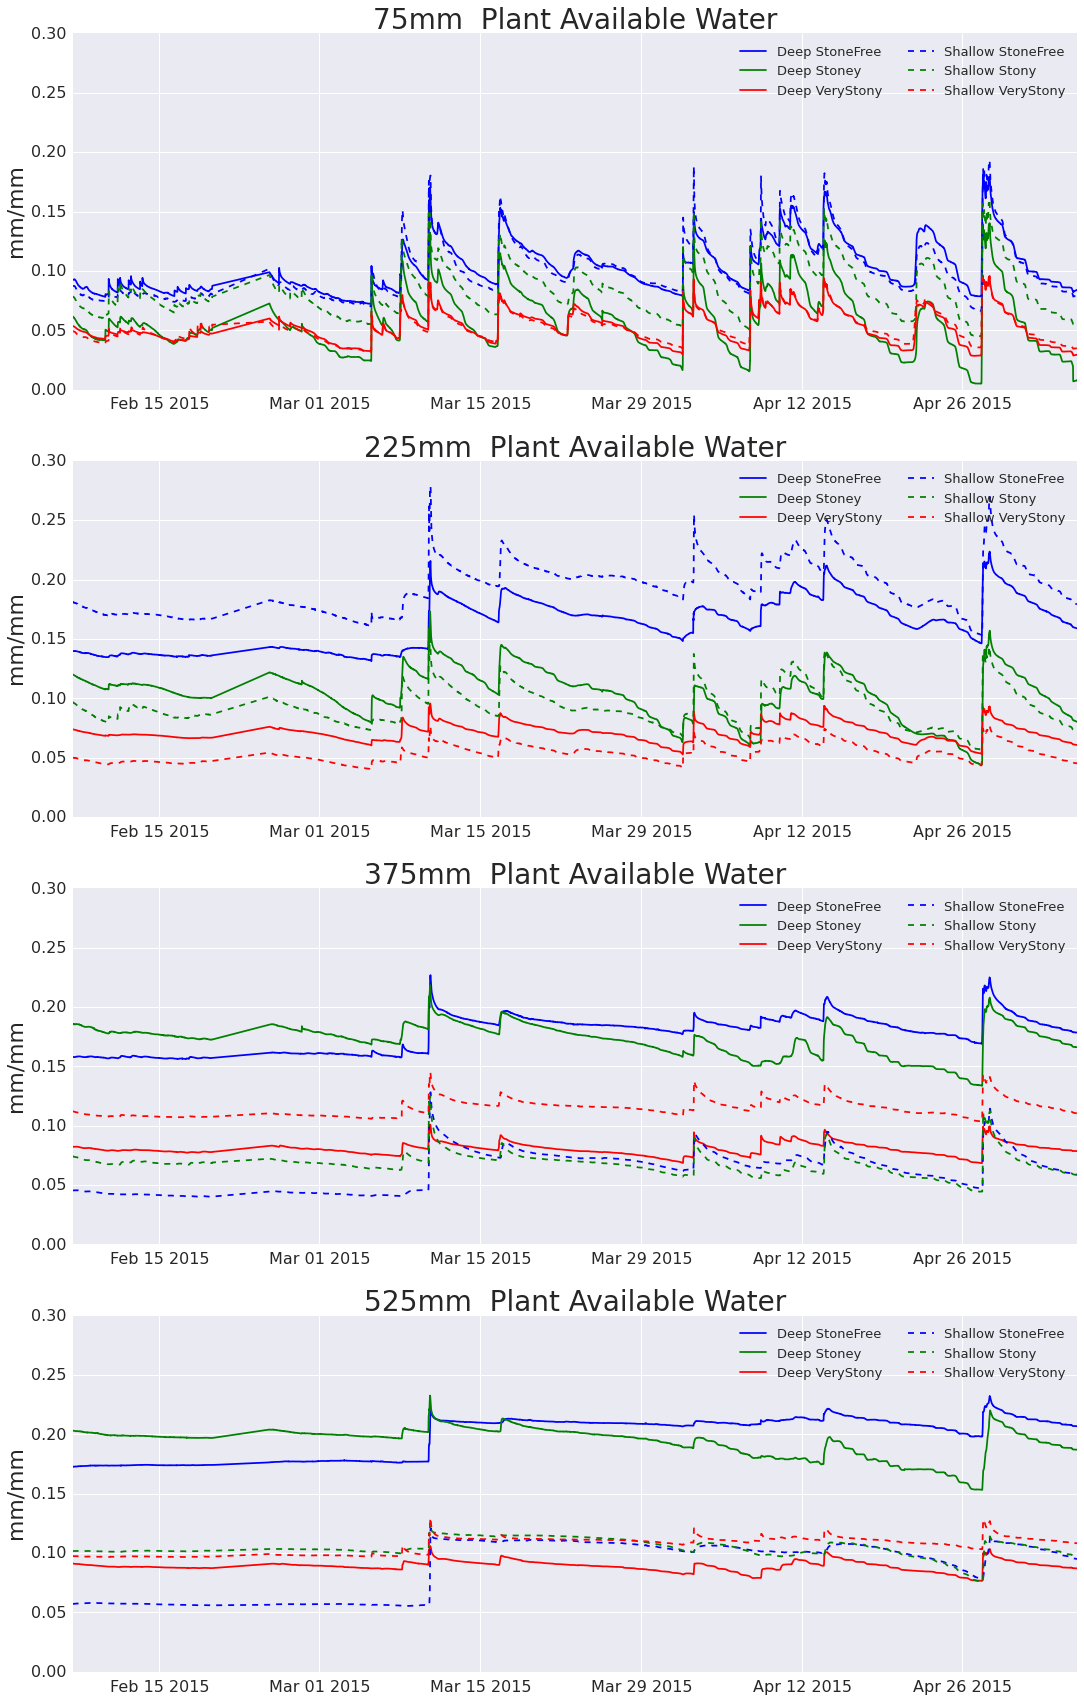

In [6]:
PAWData =  PAW.ix['2014-11-05 08:00:00':'2015-05-05',:].groupby(level=['Gravels','Stones','Depth'],axis=1).mean()
PAWData.where(PAWData<0.5,np.nan,inplace=True)

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, LayerThickness, Ymax, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','g','r','b','g','r'])
        plt.title(DepthLabel + '  Plant Available Water', fontsize=28);
        plt.plot(PAWData.index,PAWData.Deep.StoneFree.ix[:,Depth]*LayerThickness, '-', label='Deep StoneFree');
        plt.plot(PAWData.index,PAWData.Deep.Stony.ix[:,Depth]*LayerThickness, '-', label='Deep Stoney');
        plt.plot(PAWData.index,PAWData.Deep.VeryStony.ix[:,Depth]*LayerThickness,'-', label='Deep VeryStony');
        plt.plot(PAWData.index,PAWData.Shallow.StoneFree.ix[:,Depth]*LayerThickness, '--', label='Shallow StoneFree');
        plt.plot(PAWData.index,PAWData.Shallow.Stony.ix[:,Depth]*LayerThickness, '--', label='Shallow Stony');
        plt.plot(PAWData.index,PAWData.Shallow.VeryStony.ix[:,Depth]*LayerThickness, '--', label='Shallow VeryStony');
        plt.ylabel('mm/mm', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(0,Ymax);
        plt.legend(loc=1, fontsize=13, ncol=2)
        return;

MakePlot(1,'D1',1,.3, '75mm')
MakePlot(2,'D2',1,.3, '225mm')
MakePlot(3,'D3',1,.3, '375mm')
MakePlot(4,'D4',1,.3, '525mm')

##Set up a series with DUL values and assign these to HorizonIndex

In [7]:
#Assume values on 26 June represent DUL.  This was following large rainfall on the 24th of June allowing two 
#days of drainage.  ET was very low during these two days so evaporative losses would have been small.
DULValues = Data.ix['2015-06-26 12:00:00',:].copy()

#Get rid of all the index columns that I don't need leaving only the sensor reference as an index
DULValues.columns = DULValues.columns.droplevel('Gravels')
DULValues.columns = DULValues.columns.droplevel('Stones')
DULValues.columns = DULValues.columns.droplevel('Column')
DULValues.columns = DULValues.columns.droplevel('Depth')
DULValues.columns = DULValues.columns.droplevel('MUX')
DULValues.columns = DULValues.columns.droplevel('Port')
DULValues.columns = DULValues.columns.droplevel('Units')
DULValues.columns = DULValues.columns.droplevel('Summary')
DULValues.columns = DULValues.columns.droplevel('Block')
DULValues.columns = DULValues.columns.droplevel('Treatment')

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    HorizonIndex.ix[X,'DUL'] = DULValues.ix['2015-06-26 12:00:00',SensorRef] 

##Create and populate a Relative Plant Available Water (RPAW) data frame

In [8]:
#Set up empty dataframe with the same index and column structure as TDR data to hold Relative Plant Available Water values
RPAW = pd.DataFrame(index = PAW.index, columns = PAW.columns)  

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    Horizon = HorizonIndex.ix[X,'Horizon']
    LL = SensorCoefficients.ix[Horizon,'LL']
    PAWC = HorizonIndex.ix[X,'DUL'] - LL
    RPAW[SensorRef] = PAW[SensorRef].divide(PAWC)

##Graph Relative Plant Available Water

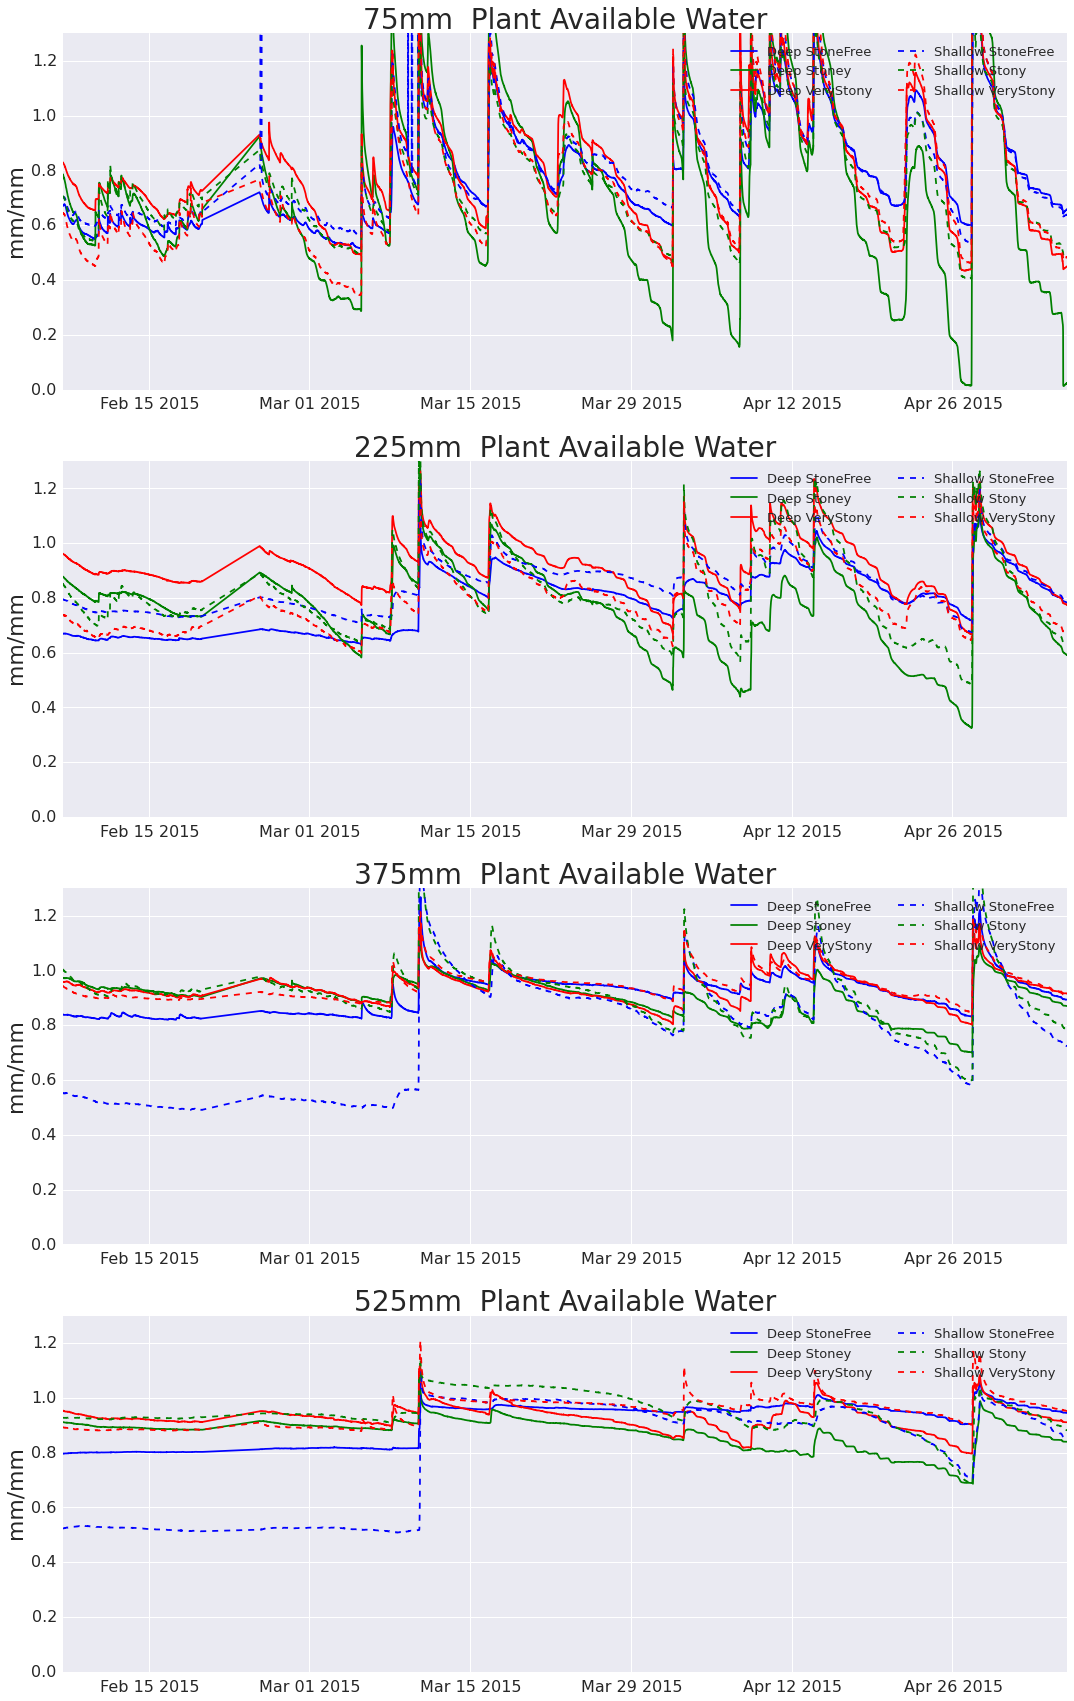

In [9]:
RPAWMeans =  RPAW.ix['2014-11-05 08:00:00':'2015-05-05',:].groupby(level=['Gravels','Stones','Depth'],axis=1).mean()

Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, LayerThickness, Ymax, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','g','r','b','g','r'])
        plt.title(DepthLabel + '  Plant Available Water', fontsize=28);
        plt.plot(RPAWMeans.index,RPAWMeans.Deep.StoneFree.ix[:,Depth]*LayerThickness, '-', label='Deep StoneFree');
        plt.plot(RPAWMeans.index,RPAWMeans.Deep.Stony.ix[:,Depth]*LayerThickness, '-', label='Deep Stoney');
        plt.plot(RPAWMeans.index,RPAWMeans.Deep.VeryStony.ix[:,Depth]*LayerThickness,'-', label='Deep VeryStony');
        plt.plot(RPAWMeans.index,RPAWMeans.Shallow.StoneFree.ix[:,Depth]*LayerThickness, '--', label='Shallow StoneFree');
        plt.plot(RPAWMeans.index,RPAWMeans.Shallow.Stony.ix[:,Depth]*LayerThickness, '--', label='Shallow Stony');
        plt.plot(RPAWMeans.index,RPAWMeans.Shallow.VeryStony.ix[:,Depth]*LayerThickness, '--', label='Shallow VeryStony');
        plt.ylabel('mm/mm', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(0,Ymax);
        plt.legend(loc=1, fontsize=13, ncol=2)
        return;

MakePlot(1,'D1',1,1.3, '75mm')
MakePlot(2,'D2',1,1.3, '225mm')
MakePlot(3,'D3',1,1.3, '375mm')
MakePlot(4,'D4',1,1.3, '525mm')

##Calculate Water Extraction Rate (WER) each day and graph

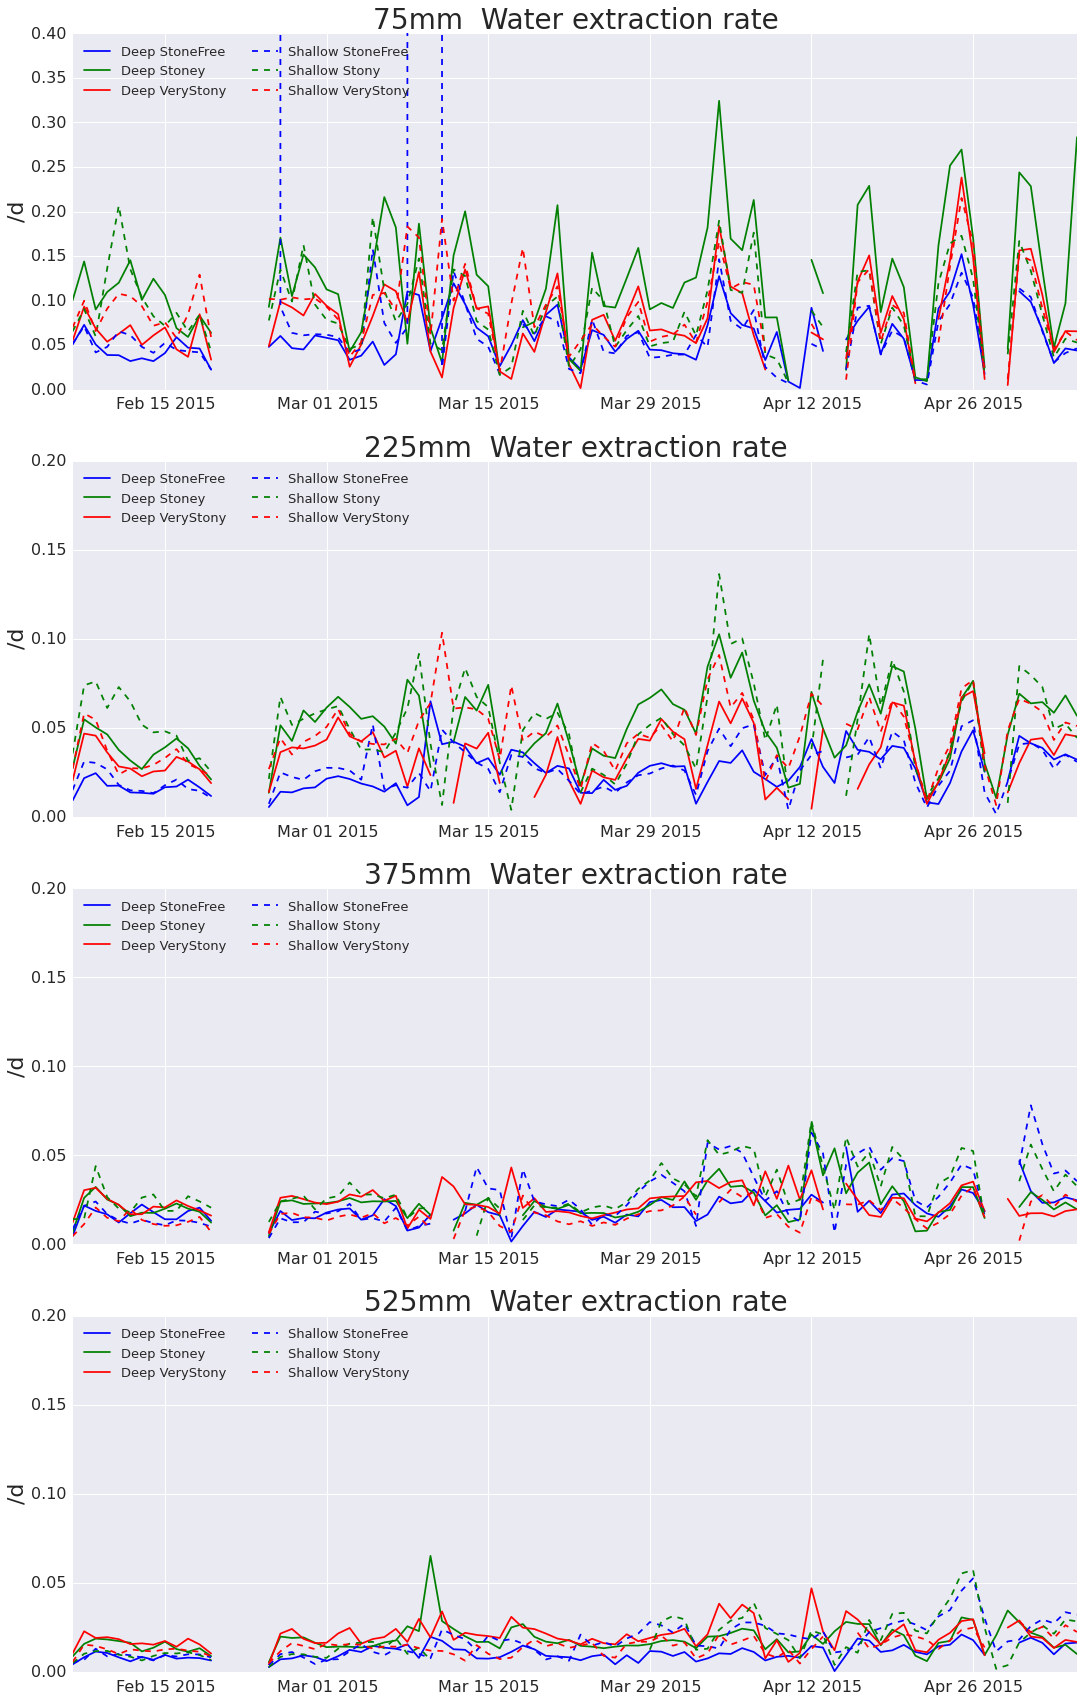

In [10]:
#Water Extraction Rate is the proportion of plant available water that is extracted each day so calculated as the difference between 
#RPAW each day
WER = RPAW.diff() * -1
WER.where(RPAW<0.98,np.nan,inplace=True)
WER.where(WER>0,np.nan,inplace=True)
DailyWER = WER.resample('D', how ='sum')

WERMean = DailyWER.ix['2014-11-05 08:00:00':'2015-05-05'].groupby(level=['Gravels','Stones','Depth'],axis=1).mean()
Fig = plt.figure(figsize=(18, 60))

def MakePlot(Position, Depth, LayerThickness, Ymax, DepthLabel):
        Fig.add_subplot(8,1,Position, color_cycle=['b','g','r','b','g','r'])
        plt.title(DepthLabel + '  Water extraction rate', fontsize=28);
        plt.plot(WERMean.index,WERMean.Deep.StoneFree.ix[:,Depth]*LayerThickness, '-', label='Deep StoneFree');
        plt.plot(WERMean.index,WERMean.Deep.Stony.ix[:,Depth]*LayerThickness, '-', label='Deep Stoney');
        plt.plot(WERMean.index,WERMean.Deep.VeryStony.ix[:,Depth]*LayerThickness,'-', label='Deep VeryStony');
        plt.plot(WERMean.index,WERMean.Shallow.StoneFree.ix[:,Depth]*LayerThickness, '--', label='Shallow StoneFree');
        plt.plot(WERMean.index,WERMean.Shallow.Stony.ix[:,Depth]*LayerThickness, '--', label='Shallow Stony');
        plt.plot(WERMean.index,WERMean.Shallow.VeryStony.ix[:,Depth]*LayerThickness, '--', label='Shallow VeryStony');
        plt.ylabel('/d', fontsize=22);
        plt.tick_params(labelsize=16);
        plt.ylim(-0,Ymax);
        plt.legend(loc=2, fontsize=13, ncol=2)
        return;

MakePlot(1,'D1',1,.4, '75mm')
MakePlot(2,'D2',1,.2, '225mm')
MakePlot(3,'D3',1,.2, '375mm')
MakePlot(4,'D4',1,.2, '525mm')

##Interpreting Water Extractino rates
There is daily variation in WER within each layer.  This is because on many days water extraction is limited by atmospherid demand.  It is the maximimum (excluding some outlyers) that represents the potential water extraction rate (kl) given by the soil hydraulic conductivity (k) and the crop root length density (l).

To calculate kl we will take the 80th percentile of WER for each layer

##Calculate kl values for each treatment and graph

In [11]:
DailyWER.dropna(inplace = True)

kl = pd.DataFrame(columns = Data.columns)

for X in range (1,97): 
    SensorRef = 'S_' + np.str(X)
    kl.ix['kl',SensorRef] = np.percentile(DailyWER[SensorRef],95)

#For some reason the above opperation makes numbers into object types so need to convert them to floats.
kl = kl.astype(float)   

#Calculate means
klMeans = kl.groupby(level=['Gravels','Stones','Depth'],axis=1).mean()
#turn the index columns into data so it can be graphed
kltranspose = klMeans.transpose()

(array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25]),
 <a list of 6 Text yticklabel objects>)

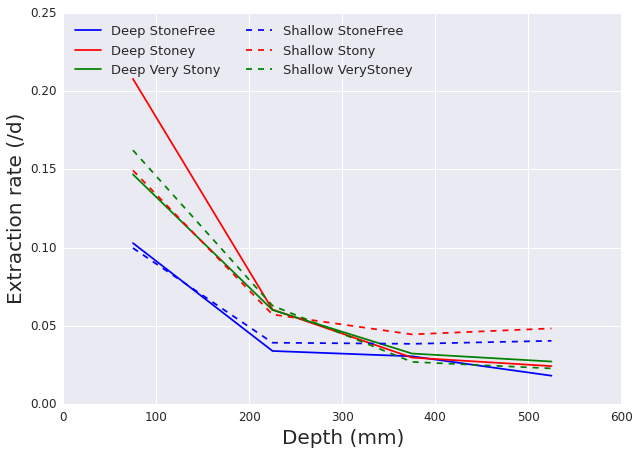

In [21]:
#Fig = plt.figure(figsize=(10,10))
#plt.plot(kltranspose.index,kltranspose.ix[('Deep','StoneFree')])
depth = [75,225,375,525]
Fig = plt.figure(figsize=(10,7))
plt.plot(depth,kltranspose.ix[('Deep','StoneFree')].values,'b-', label='Deep StoneFree')
plt.plot(depth,kltranspose.ix[('Deep','Stony')].values,'r-', label='Deep Stoney')
plt.plot(depth,kltranspose.ix[('Deep','VeryStony')].values,'g-', label='Deep Very Stony')
plt.plot(depth,kltranspose.ix[('Shallow','StoneFree')].values,'b--', label='Shallow StoneFree')
plt.plot(depth,kltranspose.ix[('Shallow','Stony')].values,'r--', label='Shallow Stony')
plt.plot(depth,kltranspose.ix[('Shallow','VeryStony')].values,'g--', label='Shallow VeryStoney')
plt.legend(loc=2, fontsize=13, ncol=2)
plt.ylabel('Extraction rate (/d)', fontsize=20);
plt.xlabel('Depth (mm)', fontsize=20);
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

AttributeError: 'DataFrame' object has no attribute 'D1'

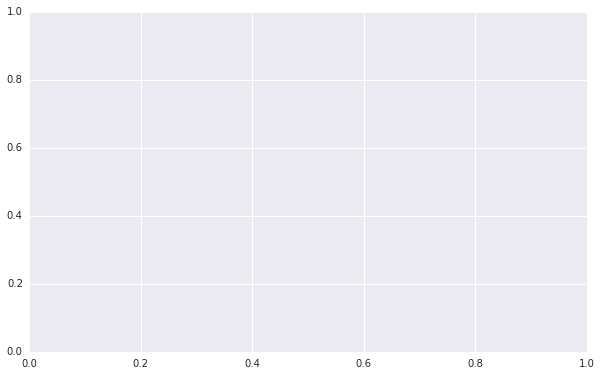

In [13]:
lables = ['Deep StoneFree','Deep Stoney','Deep VeryStony','Shallow StoneFree','Shallow Stony','Shallow VeryStony']

Fig = plt.figure(figsize=(10, 28))
Fig.add_subplot(4,1,1)
plt.boxplot(WERMean.D1.values, )
plt.xticks([1, 2, 3,4,5,6], ['Deep StoneFree','Deep Stoney','Deep VeryStony','Shallow StoneFree','Shallow Stony','Shallow VeryStony'])
plt.ylim(0,0.5)

Fig = plt.figure(figsize=(10, 28))
Fig.add_subplot(4,1,2)
plt.boxplot(WERMean.D2.values, )
plt.xticks([1, 2, 3,4,5,6], ['Deep StoneFree','Deep Stoney','Deep VeryStony','Shallow StoneFree','Shallow Stony','Shallow VeryStony'])

Fig = plt.figure(figsize=(10, 28))
Fig.add_subplot(4,1,1)
plt.boxplot(WERMean.D3.values, )
plt.xticks([1, 2, 3,4,5,6], ['Deep StoneFree','Deep Stoney','Deep VeryStony','Shallow StoneFree','Shallow Stony','Shallow VeryStony'])

Fig = plt.figure(figsize=(10, 28))
Fig.add_subplot(4,1,2)
plt.boxplot(WERMean.D4.values, )
plt.xticks([1, 2, 3,4,5,6], ['Deep StoneFree','Deep Stoney','Deep VeryStony','Shallow StoneFree','Shallow Stony','Shallow VeryStony'])

In [ ]:
#!gist -p -d "Setting up Soil summary for Export" SoilWaterAnalysis.ipynb

In [ ]:
!gist -u https://gist.github.com/604c4dfd746733297790 SoilWaterAnalysis.ipynb